## Modelling

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from python_files.data import GetData
from sklearn.model_selection import learning_curve
from python_files.basic_preprocessing import BasicPreprocessing
from python_files.preprocessing import Advancedprocessing
from sklearn.model_selection import train_test_split
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import collections
import re
import itertools
import string
from functools import reduce
from datetime import datetime
import pickle

import xgboost as xgb
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from sklearn.base import TransformerMixin, BaseEstimator
from scipy import stats
from scipy.stats import pearsonr
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, make_scorer, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import FunctionTransformer
from wordcloud import WordCloud
from sklearn.decomposition import PCA

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
data = GetData().get_data()['AllMoviesDetailsCleaned']
data.head()

,id,budget,genres,imdb_id,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,actor1_name,actor1_gender,actor2_name,actor2_gender,actor3_name,actor3_gender,actor4_name,actor4_gender,actor5_name,actor5_gender,actor_number,director_name,director_gender,director_number,producer_name,producer_number,screeplay_name,editor_name,belongs_to_collection
0,2,0.0,Drama|Crime,tt0094675,fi,Ariel,Taisto Kasurinen is a Finnish coal miner whose...,0.823904,Villealfa Filmproduction Oy,Finland,21/10/1988,0.0,69.0,suomi,Released,NaN,Ariel,7.1,40,2,1,2,Turo Pajala,0,Susanna Haavisto,0.0,Matti Pellonpää,2,Eetu Hilkamo,0,none,0,4,Aki Kaurismäki,0.0,1,none,0,Aki Kaurismäki,Raija Talvio,NaN
1,3,0.0,Drama|Comedy,tt0092149,fi,Varjoja paratiisissa,"An episode in the life of Nikander, a garbage ...",0.474450,Villealfa Filmproduction Oy,Finland,16/10/1986,0.0,76.0,English,Released,NaN,Shadows in Paradise,7.0,32,1,1,3,Matti Pellonpää,2,Kati Outinen,1.0,Sakari Kuosmanen,2,Esko Nikkari,2,Kylli Köngäs,0,7,Aki Kaurismäki,0.0,1,Mika Kaurismäki,1,Aki Kaurismäki,Raija Talvio,NaN
2,5,4000000.0,Crime|Comedy,tt0113101,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698000,Miramax Films,United States of America,25/12/1995,4300000.0,98.0,English,Released,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485,2,1,1,Tim Roth,2,Antonio Banderas,2.0,Jennifer Beals,1,Madonna,1,Marisa Tomei,1,24,Allison Anders,1.0,4,Lawrence Bender,1,none,Margaret Goodspeed,NaN
3,6,0.0,Action|Thriller|Crime,tt0107286,en,Judgment Night,"While racing to a boxing match, Frank, Mike, J...",1.322870,Universal Pictures,Japan,15/10/1993,12136938.0,110.0,English,Released,Don't move. Don't whisper. Don't even breathe.,Judgment Night,6.5,69,3,2,1,Emilio Estevez,2,Cuba Gooding Jr.,2.0,Denis Leary,2,Jeremy Piven,2,Peter Greene,2,15,Stephen Hopkins,2.0,1,Gene Levy,1,Lewis Colick,Tim Wellburn,NaN
4,8,42000.0,Documentary,tt0825671,en,Life in Loops (A Megacities RMX),Timo Novotny labels his new project an experim...,0.054716,inLoops,Austria,01/01/2006,0.0,80.0,English,Released,A Megacities remix.,Life in Loops (A Megacities RMX),6.4,4,1,1,5,none,0,none,0.0,none,0,none,0,none,0,0,Timo Novotny,0.0,1,Timo Novotny,2,Michael Glawogger,Timo Novotny,NaN


In [4]:
df = data.copy()

In [5]:
df_cleaned = BasicPreprocessing().apply(df)
df_cleaned.head()

,id,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,actor1_name,actor1_gender,actor2_name,actor2_gender,actor3_name,actor3_gender,actor4_name,actor4_gender,actor5_name,actor5_gender,actor_number,director_name,director_gender,director_number,producer_name,producer_number,screeplay_name,editor_name,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
2,5,4000000.0,Crime|Comedy,en,Four Rooms,It's Ted the Bellhop's first night on the job....,1.698000,Miramax Films,United States of America,25/12/1995,4300000.0,98.0,Twelve outrageous guests. Four scandalous requ...,Four Rooms,6.5,485,2,1,1,Tim Roth,2,Antonio Banderas,2.0,Jennifer Beals,1,Madonna,1,Marisa Tomei,1,24,Allison Anders,1.0,4,Lawrence Bender,1,none,Margaret Goodspeed,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,11,11000000.0,Adventure|Action|Science Fiction,en,Star Wars,Princess Leia is captured and held hostage by ...,10.492614,Lucasfilm,United States of America,25/05/1977,775398007.0,121.0,"A long time ago in a galaxy far, far away...",Star Wars,8.0,6168,2,1,1,Mark Hamill,2,Harrison Ford,2.0,Carrie Fisher,1,Peter Cushing,2,Alec Guinness,2,106,George Lucas,2.0,1,Gary Kurtz,2,none,Marcia Lucas,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7,12,94000000.0,Animation|Family,en,Finding Nemo,"Nemo, an adventurous young clownfish, is unexp...",9.915573,Pixar Animation Studios,United States of America,30/05/2003,940335536.0,100.0,"There are 3.7 trillion fish in the ocean, they...",Finding Nemo,7.6,5531,1,1,1,Albert Brooks,2,Ellen DeGeneres,1.0,Alexander Gould,2,Willem Dafoe,2,Brad Garrett,2,24,Andrew Stanton,2.0,1,Graham Walters,1,Andrew Stanton,David Ian Salter,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
8,13,55000000.0,Comedy|Drama|Romance,en,Forrest Gump,A man with a low IQ has accomplished great thi...,10.351236,Paramount Pictures,United States of America,06/07/1994,677945399.0,142.0,"The world will never be the same, once you've ...",Forrest Gump,8.2,7204,1,1,1,Tom Hanks,2,Robin Wright,1.0,Gary Sinise,2,Mykelti Williamson,2,Sally Field,1,67,Robert Zemeckis,2.0,1,Wendy Finerman,3,Eric Roth,Arthur Schmidt,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
9,14,15000000.0,Drama,en,American Beauty,"Lester Burnham, a depressed suburban father in...",8.191009,DreamWorks SKG,United States of America,15/09/1999,356296601.0,122.0,Look closer.,American Beauty,7.9,2994,2,1,1,Kevin Spacey,2,Annette Bening,1.0,Thora Birch,1,Wes Bentley,2,Mena Suvari,1,41,Sam Mendes,2.0,1,Bruce Cohen,2,Alan Ball,Christopher Greenbury,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
df_cleaned.isna().sum()

id                               0
budget                           0
genres                          34
original_language                0
original_title                   0
overview                        34
popularity                       0
production_companies             0
production_countries             0
release_date                     0
revenue                          0
runtime                         15
tagline                        880
title                            0
vote_average                     0
vote_count                       0
production_companies_number      0
production_countries_number      0
spoken_languages_number          0
actor1_name                      0
actor1_gender                    0
actor2_name                      0
actor2_gender                    0
actor3_name                      0
actor3_gender                    0
actor4_name                      0
actor4_gender                    0
actor5_name                      0
actor5_gender       

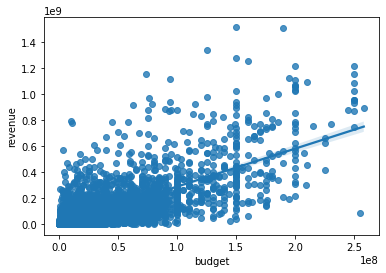

In [7]:
import seaborn as sns
sns.regplot(x='budget', y='revenue', data=df_cleaned);

In [8]:
round(df_cleaned.corr(), 2)

,id,budget,popularity,revenue,runtime,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,actor1_gender,actor2_gender,actor3_gender,actor4_gender,actor5_gender,actor_number,director_gender,director_number,producer_number,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
id,1.00,-0.06,0.10,-0.02,0.01,-0.14,0.02,0.04,-0.02,-0.09,-0.28,-0.11,-0.15,-0.18,-0.18,0.03,-0.22,-0.03,0.02,-0.12,-0.03,-0.05,0.01,-0.02,-0.06,0.01,0.02,-0.03,-0.04,0.00,0.03,-0.03,-0.00,-0.05,-0.03,-0.06,0.03,-0.06,0.00,-0.03
budget,-0.06,1.00,0.36,0.73,0.14,0.05,0.58,0.24,0.12,0.09,0.20,0.13,0.15,0.17,0.19,0.31,0.16,0.03,0.21,0.21,0.27,0.37,0.19,-0.05,-0.02,-0.07,-0.20,0.22,0.25,-0.07,-0.00,-0.11,-0.05,0.00,-0.12,0.20,-0.01,0.03,0.00,-0.00
popularity,0.10,0.36,1.00,0.47,0.07,0.18,0.51,0.13,0.09,0.04,0.08,0.09,0.09,0.09,0.11,0.28,0.08,0.03,0.14,0.16,0.10,0.15,0.08,-0.06,-0.00,-0.04,-0.07,0.08,0.11,-0.05,-0.00,-0.02,-0.03,0.01,-0.06,0.12,-0.01,0.04,0.01,-0.00
revenue,-0.02,0.73,0.47,1.00,0.14,0.18,0.76,0.13,0.04,0.07,0.13,0.11,0.10,0.11,0.14,0.35,0.13,0.05,0.13,0.36,0.16,0.32,0.20,-0.03,-0.05,-0.05,-0.18,0.21,0.21,-0.05,-0.04,-0.07,-0.03,-0.02,-0.07,0.13,-0.01,-0.02,-0.02,-0.03
runtime,0.01,0.14,0.07,0.14,1.00,0.26,0.16,0.04,0.07,0.16,0.10,0.06,0.02,0.02,0.04,0.21,0.07,-0.07,0.07,-0.08,0.08,0.05,-0.21,-0.23,0.02,-0.05,0.26,-0.17,-0.04,0.08,0.24,-0.16,0.01,0.01,0.08,-0.03,-0.01,-0.01,0.15,0.07
vote_average,-0.14,0.05,0.18,0.18,0.26,1.00,0.30,0.10,0.07,0.13,0.17,0.12,0.10,0.09,0.10,0.21,0.14,0.04,0.12,0.01,-0.07,0.02,0.04,-0.12,0.05,0.03,0.21,-0.00,-0.01,-0.07,0.09,-0.12,0.03,0.04,-0.01,-0.03,-0.05,-0.02,0.08,0.05
vote_count,0.02,0.58,0.51,0.76,0.16,0.30,1.00,0.20,0.08,0.08,0.15,0.12,0.11,0.13,0.15,0.41,0.15,0.03,0.20,0.28,0.16,0.23,0.09,-0.09,0.01,-0.05,-0.12,0.08,0.15,-0.06,-0.04,-0.04,-0.05,0.01,-0.10,0.20,-0.01,0.04,-0.01,-0.00
production_companies_number,0.04,0.24,0.13,0.13,0.04,0.10,0.20,1.00,0.48,0.13,0.08,0.11,0.09,0.08,0.09,0.16,0.09,0.00,0.37,0.02,0.09,0.06,-0.02,-0.12,0.06,-0.04,0.02,-0.04,0.06,-0.08,0.02,0.02,-0.04,0.03,-0.09,0.08,-0.01,0.11,0.04,-0.02
production_countries_number,-0.02,0.12,0.09,0.04,0.07,0.07,0.08,0.48,1.00,0.18,0.03,0.04,0.02,0.05,0.05,0.06,0.05,-0.01,0.18,0.04,0.07,0.07,-0.04,-0.14,0.01,-0.02,0.04,-0.02,0.05,-0.02,0.09,0.03,-0.03,0.03,-0.03,0.06,0.02,0.08,0.09,0.00
spoken_languages_number,-0.09,0.09,0.04,0.07,0.16,0.13,0.08,0.13,0.18,1.00,0.09,0.04,0.02,0.04,0.04,0.07,0.05,0.04,0.08,0.03,0.12,0.06,-0.03,-0.08,0.06,-0.00,0.03,-0.07,-0.04,-0.02,0.13,-0.04,-0.02,0.01,-0.02,-0.01,-0.01,0.10,0.15,0.01


In [9]:
df_cleaned.shape

(5313, 58)

In [10]:
df_cleaned.columns

Index(['id', 'budget', 'genres', 'original_language', 'original_title',
       'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime', 'tagline',
       'title', 'vote_average', 'vote_count', 'production_companies_number',
       'production_countries_number', 'spoken_languages_number', 'actor1_name',
       'actor1_gender', 'actor2_name', 'actor2_gender', 'actor3_name',
       'actor3_gender', 'actor4_name', 'actor4_gender', 'actor5_name',
       'actor5_gender', 'actor_number', 'director_name', 'director_gender',
       'director_number', 'producer_name', 'producer_number', 'screeplay_name',
       'editor_name', 'collection', 'Action', 'Adventure', 'Animation',
       'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy',
       'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance',
       'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western'],
      dtype='object')

In [11]:
df_cleaned.describe()

,id,budget,popularity,revenue,runtime,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,actor1_gender,actor2_gender,actor3_gender,actor4_gender,actor5_gender,actor_number,director_gender,director_number,producer_number,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
count,5313.000000,5.313000e+03,5313.000000,5.313000e+03,5298.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000,5313.000000
mean,64291.503106,3.048223e+07,2.257955,8.714463e+07,110.603813,6.158291,638.417843,2.851496,1.347826,1.474497,1.594579,1.421796,1.402221,1.404291,1.374177,22.723132,1.560512,1.079992,2.131564,0.218521,0.264634,0.175983,0.054960,0.343309,0.155656,0.010540,0.474497,0.098061,0.094109,0.010164,0.045172,0.101637,0.034444,0.081498,0.191417,0.111613,0.000376,0.274233,0.036891,0.015998
std,99640.383145,3.869750e+07,4.380645,1.539707e+08,23.844999,1.160001,1096.512286,2.189783,0.794988,0.924360,0.657258,0.672692,0.706501,0.744152,0.778347,19.973899,0.802715,0.512091,1.720767,0.413281,0.441180,0.380842,0.227923,0.474858,0.362563,0.102133,0.499396,0.297426,0.292007,0.100311,0.207701,0.302199,0.182383,0.273624,0.393454,0.314919,0.019400,0.446169,0.188511,0.125481
min,5.000000,3.100000e+05,0.000012,3.003000e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8859.000000,5.000000e+06,0.726791,6.808550e+06,96.000000,5.700000,58.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,2.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15049.000000,1.600000e+07,1.559399,2.860752e+07,107.000000,6.300000,237.000000,2.000000,1.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,17.000000,2.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68351.000000,4.000000e+07,2.707114,9.812656e+07,121.000000,6.900000,708.000000,4.000000,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,26.000000,2.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,468938.000000,2.580000e+08,156.093026,1.513529e+09,338.000000,10.000000,12811.000000,26.000000,12.000000,9.000000,2.000000,2.000000,2.000000,2.000000,2.000000,313.000000,2.000000,21.000000,22.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [12]:
Q1 = df_cleaned['revenue'].quantile(0.25)

Q3 = df_cleaned['revenue'].quantile(0.75)

IQR = Q3 - Q1

print(f'{IQR:,}')

91,318,015.0


In [13]:
print(df_cleaned['revenue'].skew())

3.629360720910589


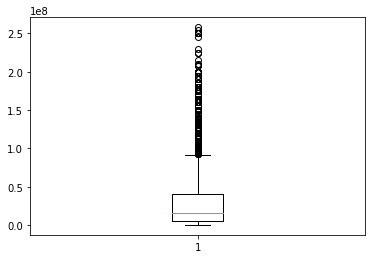

In [14]:
plt.boxplot(df_cleaned['budget'])

plt.show()

In [15]:
df_cleaned['budget'].sort_values(ascending = False)

439       258000000.0
39838     255000000.0
218582    250000000.0
81324     250000000.0
609       250000000.0
             ...     
2044         325000.0
17564        322000.0
122576       318000.0
38203        312000.0
112720       310000.0
Name: budget, Length: 5313, dtype: float64

### Splitting data into train and test sets

In [16]:
X = df_cleaned.drop(columns = ['revenue'])
y = df_cleaned['revenue']

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)

# Print split result
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(4250, 57)
(1063, 57)
(4250,)
(1063,)


In [18]:
X_train.head()

,id,budget,genres,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,runtime,tagline,title,vote_average,vote_count,production_companies_number,production_countries_number,spoken_languages_number,actor1_name,actor1_gender,actor2_name,actor2_gender,actor3_name,actor3_gender,actor4_name,actor4_gender,actor5_name,actor5_gender,actor_number,director_name,director_gender,director_number,producer_name,producer_number,screeplay_name,editor_name,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
10256,16888,24000000.0,Comedy,en,The Ladies Man,"Because of his salacious language, late-night ...",0.353470,SNL Studios,United States of America,13/10/2000,84.0,He's cool. He's clean. He's a love machine.,The Ladies Man,5.6,30,1,1,1,Tim Meadows,2,Karyn Parsons,1.0,Billy Dee Williams,0,John Witherspoon,2,Jill Talley,1,23,Reginald Hudlin,2.0,1,Lorne Michaels,1,none,Earl Watson,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
187414,302401,40000000.0,Drama|Thriller,en,Snowden,CIA employee Edward Snowden leaks thousands of...,3.712921,Endgame Entertainment,Germany,15/09/2016,134.0,The only safe place is on the run.,Snowden,7.0,1145,3,2,1,Joseph Gordon-Levitt,2,Shailene Woodley,1.0,Melissa Leo,1,Zachary Quinto,2,Tom Wilkinson,2,39,Oliver Stone,2.0,1,Moritz Borman,4,Oliver Stone,Lee Percy,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
910,1372,100000000.0,Drama|Thriller|Action,en,Blood Diamond,An ex-mercenary turned smuggler. A Mende fishe...,4.111459,Bedford Falls Productions,Germany,07/12/2006,143.0,It will cost you everything.,Blood Diamond,7.3,2101,7,2,2,Leonardo DiCaprio,2,Djimon Hounsou,2.0,Jennifer Connelly,1,Kagiso Kuypers,0,Arnold Vosloo,2,22,Edward Zwick,2.0,1,Gillian Gorfil,9,Charles Leavitt,Steven Rosenblum,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
6240,11165,25485000.0,History|Action|Drama|Adventure|War,en,Tora! Tora! Tora!,"In the summer of 1941, the United States and J...",0.689956,Twentieth Century Fox Film Corporation,Japan,26/01/1970,144.0,The incredible attack on Pearl Harbor.,Tora! Tora! Tora!,6.9,136,1,2,2,Martin Balsam,2,Sô Yamamura,2.0,Joseph Cotten,2,Tatsuya Mihashi,2,E.G. Marshall,2,30,Richard Fleischer,0.0,3,Elmo Williams,1,Larry Forrester,Pembroke J. Herring,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0
36423,52891,3000000.0,Comedy,ru,Gitler kaput!,A Russian WW2 spy spoof following misadventure...,0.290329,Leopolis,Ukraine,18/09/2008,99.0,NaN,Hitler's Kaput!,3.6,7,1,2,2,Pavel Derevyanko,0,Anna Semenovich,0.0,Yuriy Galtsev,0,Yuriy Stoyanov,2,Aleksey Ogurtsov,0,16,Marius Balchunas,2.0,1,none,0,none,none,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
X_train_processed, list_top_30 = Advancedprocessing.process(X_train)
X_test_processed, _ = Advancedprocessing.process(X_test, train_set=False)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/pandas/core/arrays/datetimes.py:2224: FutureWarning: The parsing of 'now' in pd.to_datetime without `utc=True` is deprecated. In a future version, this will match Timestamp('now') and Timestamp.now()
  result, tz_parsed = tslib.array_to_datetime(
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataset[header_name] = dataset[col].apply(lambda x: 1 if item in x else 0)
/home/sourav/code/Urus1201/data-movie-revenue-prediction/python_files/preprocessing.py:34: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor perform

director_name
['Steven Spielberg', 'Woody Allen', 'Clint Eastwood', 'Brian De Palma', 'Tim Burton', 'Robert Zemeckis', 'Ridley Scott', 'Alfred Hitchcock', 'Martin Scorsese', 'Oliver Stone', 'Steven Soderbergh', 'Tony Scott', 'Joel Schumacher', 'Robert Rodriguez', 'Wes Craven', 'Ron Howard', 'Renny Harlin', 'Barry Levinson', 'Richard Donner', 'Spike Lee', 'Richard Linklater', 'Walter Hill', 'Paul W.S. Anderson', 'Francis Ford Coppola', 'Peter Hyams', 'Roland Emmerich', 'Gore Verbinski', 'Sam Raimi', 'Ang Lee', 'Rob Reiner']
producer_name
['Joel Silver', 'Brian Grazer', 'Jerry Bruckheimer', 'Scott Rudin', 'John Davis', 'Tim Bevan', 'Neal H. Moritz', 'Arnon Milchan', 'Roger Birnbaum', 'Clint Eastwood', 'Michael Bay', 'Steve Golin', 'Tom Rosenberg', 'Judd Apatow', 'Luc Besson', 'James G. Robinson', 'Charles Roven', 'Albert R. Broccoli', 'Alfred Hitchcock', 'Danny DeVito', 'Kevin Feige', 'John Hughes', 'Ronnie Screwvala', 'Steven Spielberg', 'Gale Anne Hurd', 'Lorenzo di Bonaventura', 'Sydn

In [20]:
X_train_processed.popularity.isna().sum()

0

In [21]:
X_train_processed[['week_sin','week_cos']] = X_train_processed[['week_sin','week_cos']].astype('float64')
X_test_processed[['week_sin','week_cos']] = X_test_processed[['week_sin','week_cos']].astype('float64')

In [22]:
# Create validation sets
X_train_processed_part, X_val, y_train_part, y_val = train_test_split(X_train_processed, 
                                                              y_train, 
                                                              test_size = 0.2,
                                                              random_state = 42)

# Print split result
print(X_train_processed_part.shape)
print(X_val.shape)
print(y_train_part.shape)
print(y_val.shape)

(3400, 150)
(850, 150)
(3400,)
(850,)


In [23]:
# transform the y test and train to log scale
y_train_part_log = y_train_part.apply(lambda x: np.log(x + 1))
y_val_log = y_val.apply(lambda x: np.log(x + 1))
y_test_log = y_test.apply(lambda x: np.log(x + 1))

In [24]:
# Min max scaler for budget (log)
# minmax_scaler = MinMaxScaler()

# X_train_processed_part['budget'] = minmax_scaler.fit_transform(X_train_processed_part[['budget']]
                                                               
# X_val['budget'] = minmax_scaler.transform(X_val[['budget']])
                                          
# X_test_processed['budget'] = minmax_scaler.transform(X_test_processed[['budget']])

In [25]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy= 'mean')

imputer.fit(X_train_processed_part[['popularity', 'runtime']])

X_train_processed_part[['popularity', 'runtime']] = imputer.transform(X_train_processed_part[['popularity', 'runtime']])
X_val[['popularity', 'runtime']] = imputer.transform(X_val[['popularity', 'runtime']])
X_test_processed[['popularity', 'runtime']] = imputer.transform(X_test_processed[['popularity', 'runtime']])

In [26]:
# RobustScaler for rest of the numerical features
rbst_scaler = RobustScaler()
features = ['runtime', 'release_age', 'production_companies_number', 'production_countries_number', 'popularity', 'vote_average', 'vote_count',
            'actor_number', 'director_number', 'producer_number', 'budget_year_ratio'] #'spoken_languages_number'

X_train_processed_part[features] = rbst_scaler.fit_transform(X_train_processed_part[features])

X_val[features] = rbst_scaler.transform(X_val[features])

X_test_processed[features] = rbst_scaler.transform(X_test_processed[features])

In [27]:
X_train_processed_part.describe()

,popularity,runtime,vote_average,vote_count,production_companies_number,production_countries_number,actor_number,director_number,producer_number,collection,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,week_sin,week_cos,release_age,budget_year_ratio,Steven Spielberg_name,Woody Allen_name,Clint Eastwood_name,Brian De Palma_name,Tim Burton_name,Robert Zemeckis_name,Ridley Scott_name,Alfred Hitchcock_name,Martin Scorsese_name,Oliver Stone_name,Steven Soderbergh_name,Tony Scott_name,Joel Schumacher_name,Robert Rodriguez_name,Wes Craven_name,Ron Howard_name,Renny Harlin_name,Barry Levinson_name,Richard Donner_name,Spike Lee_name,Richard Linklater_name,Walter Hill_name,Paul W.S. Anderson_name,Francis Ford Coppola_name,Peter Hyams_name,Roland Emmerich_name,Gore Verbinski_name,Sam Raimi_name,Ang Lee_name,Rob Reiner_name,Joel Silver_name,Brian Grazer_name,Jerry Bruckheimer_name,Scott Rudin_name,John Davis_name,Tim Bevan_name,Neal H. Moritz_name,Arnon Milchan_name,Roger Birnbaum_name,Michael Bay_name,Steve Golin_name,Tom Rosenberg_name,Judd Apatow_name,Luc Besson_name,James G. Robinson_name,Charles Roven_name,Albert R. Broccoli_name,Danny DeVito_name,Kevin Feige_name,John Hughes_name,Ronnie Screwvala_name,Gale Anne Hurd_name,Lorenzo di Bonaventura_name,Sydney Pollack_name,Mark Johnson_name,Walt Disney_name,Paramount Pictures_name,Universal Pictures_name,Twentieth Century Fox Film Corporation_name,Columbia Pictures_name,New Line Cinema_name,Walt Disney Pictures_name,Warner Bros._name,United Artists_name,Miramax Films_name,Metro-Goldwyn-Mayer (MGM)_name,Columbia Pictures Corporation_name,Village Roadshow Pictures_name,TriStar Pictures_name,DreamWorks SKG_name,Fox Searchlight Pictures_name,Summit Entertainment_name,Touchstone Pictures_name,Regency Enterprises_name,Lions Gate Films_name,Lionsgate_name,Imagine Entertainment_name,The Weinstein Company_name,Orion Pictures_name,BBC Films_name,Hollywood Pictures_name,Dimension Films_name,Lakeshore Entertainment_name,Lucasfilm_name,Fox 2000 Pictures_name,StudioCanal_name,United States of America_name,United Kingdom_name,India_name,France_name,Canada_name,Germany_name,Russia_name,Australia_name,Japan_name,Italy_name,China_name,Spain_name,Ireland_name,Mexico_name,Hong Kong_name,Belgium_name,Netherlands_name,Denmark_name,South Korea_name,Czech Republic_name,New Zealand_name,Switzerland_name,Brazil_name,Finland_name,Singapore_name,Argentina_name,Thailand_name,Norway_name,Sweden_name,Hungary_name
count,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3.400000e+03,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.000000,3400.

In [28]:
X_train_processed_part.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3400 entries, 25336 to 421
Columns: 150 entries, popularity to Hungary_name
dtypes: float64(13), int64(137)
memory usage: 3.9 MB


## Modelling

### Baseline

In [29]:
# Add scoring function
scorer = make_scorer(mean_squared_error)

In [30]:
model = LinearRegression()

In [31]:
baseline_mse_score = cross_val_score( model, X_train_processed_part, y_train_part_log, cv = 10, scoring= make_scorer(mean_squared_error)).mean()

In [32]:
np.sqrt(baseline_mse_score)

16959045463.580236

In [33]:
model.fit(X_train_processed_part, y_train_part_log)

LinearRegression()

In [34]:
# Create dataframe with predicted values
comp_df = pd.DataFrame({"actual": np.expm1(y_test_log), "predictions": np.expm1(model.predict(X_test_processed))})

# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
2704,55011732.0,4.130109e+07,-1.371064e+07,24.923127,bad
41501,11411644.0,1.321096e+07,1.799315e+06,15.767357,okay
8554,39673161.0,9.709677e+06,-2.996348e+07,75.525829,bad
5383,14697005.0,1.061717e+07,-4.079837e+06,27.759650,bad
4953,141407024.0,1.543521e+08,1.294504e+07,9.154454,okay
...,...,...,...,...,...
6830,23574130.0,1.938941e+07,-4.184720e+06,17.751323,okay
12592,13071518.0,1.637081e+07,3.299290e+06,25.240294,bad
181,6000000.0,7.947842e+06,1.947842e+06,32.464041,bad
6213,40996665.0,1.828397e+07,-2.271269e+07,55.401320,bad


<AxesSubplot:xlabel='difference', ylabel='Count'>

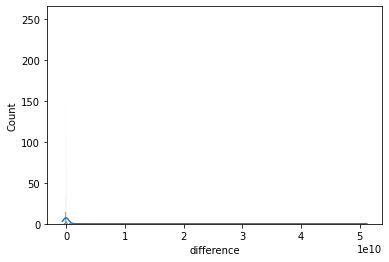

In [35]:
sns.histplot( comp_df['difference'], kde= True)

In [36]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff').reset_index()

,index,actual,predictions,difference,percent_diff,okay
0,1123,18999718.0,1.899174e+07,-7.977719e+03,0.041989,okay
1,4847,52034889.0,5.213540e+07,1.005110e+05,0.193161,okay
2,7756,43493123.0,4.362517e+07,1.320518e+05,0.303615,okay
3,186469,11122090.0,1.115778e+07,3.569311e+04,0.320921,okay
4,4830,34994648.0,3.484584e+07,-1.488109e+05,0.425239,okay
...,...,...,...,...,...,...
149,159,210000000.0,1.687990e+08,-4.120098e+07,19.619512,okay
150,38750,10000000.0,8.032283e+06,-1.967717e+06,19.677175,okay
151,833,41158757.0,4.932865e+07,8.169890e+06,19.849700,okay
152,9119,23686027.0,2.840731e+07,4.721286e+06,19.932789,okay


### XGBoost

In [37]:
# Create DMatrix for train set, cross-validation set and test set (which is X_cross)
train_set = xgb.DMatrix(X_train_processed_part, label=y_train_part_log)
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

# Define the initial parameters to use (default values)
parameters_xgb = {'learning_rate': 0.3, 
                  'max_depth': 6, 
                  'alpha': 0, 
                  'subsample': 1,
                  'min_child_weight': 1, 
                  'colsample_bytree': 1} 

# Define the variations of each parameter to be checked
learning_rate = [0.3, 0.1, 0.01]
max_depth = [6, 8, 10]
alpha = [0, 5, 10]
subsample = [0.5, 0.7, 1]
min_child_weight = [1, 3, 6]
colsample_bytree = [0.5, 0.7, 1]

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [34]:
# This code was adapted from https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f
def grid_search_xgb(param1, param2, param1_vals, param2_vals):
    '''
    Function to simulate gridsearch on XGBoost model testing two different values at a time
    Args: param1 = string; name of first parameter
          param2 = string; name of second parameter
          param1_vals = list; values to be checked
          param2_vals = list; values to be checked
    Returns: None
    '''
    
    min_rmse = float("Inf")
    best_parameters = None
    overall_best = collections.defaultdict()

    for val1 in param1_vals:
        for val2 in param2_vals:
            parameters_xgb[param1] = val1
            parameters_xgb[param2] = val2
            cv_results_xgb = xgb.cv(params = parameters_xgb,
                                dtrain=train_set,
                                num_boost_round=1000,
                                seed=42,
                                nfold=5,
                                metrics={'rmse'},
                                early_stopping_rounds=15)

            best_rmse = cv_results_xgb['test-rmse-mean'].min() 
            boost_rounds = cv_results_xgb['test-rmse-mean'].idxmin()
            print('{}: {}, {}: {}'.format(param1, val1, param2, val2))
            print('\tRMSE {} for {} rounds'.format(best_rmse, boost_rounds))
            
            if best_rmse < min_rmse:
                min_rmse = best_rmse
                best_parameters = (val1, val2)
        
        print('Best params: {} of {}, {} of {}, RMSE: {}'.format(param1, 
                                                                 best_parameters[0], 
                                                                 param2, 
                                                                 best_parameters[1], 
                                                                 min_rmse))

In [35]:
# Gridsearch through learning_rate and max_depth values for XGBoost model
grid_search_xgb('learning_rate', 'max_depth', learning_rate, max_depth)

learning_rate: 0.3, max_depth: 6
	RMSE 1.2963418 for 19 rounds
learning_rate: 0.3, max_depth: 8
	RMSE 1.3165900000000001 for 18 rounds
learning_rate: 0.3, max_depth: 10
	RMSE 1.3319084 for 18 rounds
Best params: learning_rate of 0.3, max_depth of 6, RMSE: 1.2963418
learning_rate: 0.1, max_depth: 6
	RMSE 1.2564060000000001 for 99 rounds
learning_rate: 0.1, max_depth: 8
	RMSE 1.2647958000000001 for 94 rounds
learning_rate: 0.1, max_depth: 10
	RMSE 1.2750404 for 86 rounds
Best params: learning_rate of 0.1, max_depth of 6, RMSE: 1.2564060000000001
learning_rate: 0.01, max_depth: 6
	RMSE 1.246789 for 754 rounds
learning_rate: 0.01, max_depth: 8
	RMSE 1.2543256 for 844 rounds
learning_rate: 0.01, max_depth: 10
	RMSE 1.2620166000000002 for 936 rounds
Best params: learning_rate of 0.01, max_depth of 6, RMSE: 1.246789


😎**Inference:** _Based on the above, a learning_rate of 0.01 and a max_depth of 6 have the lowest RMSE. I will update the parameters dict._

In [36]:
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through alpha and subsample values for XGBoost model
grid_search_xgb('alpha', 'subsample', alpha, subsample)

alpha: 0, subsample: 0.5
	RMSE 1.2293488 for 791 rounds
alpha: 0, subsample: 0.7
	RMSE 1.2331642 for 757 rounds
alpha: 0, subsample: 1
	RMSE 1.246789 for 754 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2293488
alpha: 5, subsample: 0.5
	RMSE 1.241452 for 754 rounds
alpha: 5, subsample: 0.7
	RMSE 1.239265 for 980 rounds
alpha: 5, subsample: 1
	RMSE 1.2405171999999998 for 921 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2293488
alpha: 10, subsample: 0.5
	RMSE 1.2456146000000001 for 999 rounds
alpha: 10, subsample: 0.7
	RMSE 1.2474032000000002 for 927 rounds
alpha: 10, subsample: 1
	RMSE 1.2494854 for 885 rounds
Best params: alpha of 0, subsample of 0.5, RMSE: 1.2293488


😎**Inference:** _Based on the above, an alpha value of 0 and a subsample value of 0.7 have the lowest RMSE. I will update the parameters dict._

In [37]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.5
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6

# Gridsearch through min_child_weight and colsample_bytree values for XGBoost model
grid_search_xgb('min_child_weight', 'colsample_bytree', min_child_weight, colsample_bytree)

min_child_weight: 1, colsample_bytree: 0.5
	RMSE 1.2256070000000001 for 957 rounds
min_child_weight: 1, colsample_bytree: 0.7
	RMSE 1.2259988 for 834 rounds
min_child_weight: 1, colsample_bytree: 1
	RMSE 1.2293488 for 791 rounds
Best params: min_child_weight of 1, colsample_bytree of 0.5, RMSE: 1.2256070000000001
min_child_weight: 3, colsample_bytree: 0.5
	RMSE 1.2221618 for 958 rounds
min_child_weight: 3, colsample_bytree: 0.7
	RMSE 1.2192668000000002 for 786 rounds
min_child_weight: 3, colsample_bytree: 1
	RMSE 1.2186014 for 776 rounds
Best params: min_child_weight of 3, colsample_bytree of 1, RMSE: 1.2186014
min_child_weight: 6, colsample_bytree: 0.5
	RMSE 1.2233438 for 815 rounds
min_child_weight: 6, colsample_bytree: 0.7
	RMSE 1.2168546 for 785 rounds
min_child_weight: 6, colsample_bytree: 1
	RMSE 1.2159780000000002 for 774 rounds
Best params: min_child_weight of 6, colsample_bytree of 1, RMSE: 1.2159780000000002


😎**Inference:** _Based on the above, a min_child_weight value of 3 and a colsample_bytree value of 0.7 have the lowest RMSE. I will update the parameters dict._

With those updated parameters, I will predict the revenue values for the X_cross dataset.


In [38]:
# Update alpha and lambda
parameters_xgb['alpha'] = 0
parameters_xgb['subsample'] = 0.5
# Update learning_rate and max_depth
parameters_xgb['learning_rate'] = 0.01
parameters_xgb['max_depth'] = 6
# Update min_child_weight and colsample_bytree
parameters_xgb['min_child_weight'] = 6
parameters_xgb['colsample_bytree'] = 1

In [39]:
# Predicting values
test_set = xgb.DMatrix(X_val, label=y_val_log)
cross_set = xgb.DMatrix(X_test_processed, label=y_test_log)

clf_xgb = xgb.train(params = parameters_xgb,
                  dtrain = train_set,
                  num_boost_round=1000,
                  evals=[(test_set, "Test")],
                  early_stopping_rounds=100)

y_pred_xgb = clf_xgb.predict(cross_set)

[0]	Test-rmse:16.34971
[1]	Test-rmse:16.18841
[2]	Test-rmse:16.02834
[3]	Test-rmse:15.86992
[4]	Test-rmse:15.71300
[5]	Test-rmse:15.55679
[6]	Test-rmse:15.40328
[7]	Test-rmse:15.25079
[8]	Test-rmse:15.10046
[9]	Test-rmse:14.95108
[10]	Test-rmse:14.80336
[11]	Test-rmse:14.65648
[12]	Test-rmse:14.51077
[13]	Test-rmse:14.36712
[14]	Test-rmse:14.22480
[15]	Test-rmse:14.08435
[16]	Test-rmse:13.94498
[17]	Test-rmse:13.80756
[18]	Test-rmse:13.67131
[19]	Test-rmse:13.53626
[20]	Test-rmse:13.40271
[21]	Test-rmse:13.27035
[22]	Test-rmse:13.13885
[23]	Test-rmse:13.00886
[24]	Test-rmse:12.88031
[25]	Test-rmse:12.75354
[26]	Test-rmse:12.62799
[27]	Test-rmse:12.50348
[28]	Test-rmse:12.38068
[29]	Test-rmse:12.25843
[30]	Test-rmse:12.13718
[31]	Test-rmse:12.01727
[32]	Test-rmse:11.89902
[33]	Test-rmse:11.78138
[34]	Test-rmse:11.66563
[35]	Test-rmse:11.55098
[36]	Test-rmse:11.43699
[37]	Test-rmse:11.32413
[38]	Test-rmse:11.21280
[39]	Test-rmse:11.10306
[40]	Test-rmse:10.99414
[41]	Test-rmse:10.88612
[4

[344]	Test-rmse:1.26074
[345]	Test-rmse:1.25868
[346]	Test-rmse:1.25652
[347]	Test-rmse:1.25441
[348]	Test-rmse:1.25238
[349]	Test-rmse:1.25028
[350]	Test-rmse:1.24834
[351]	Test-rmse:1.24640
[352]	Test-rmse:1.24452
[353]	Test-rmse:1.24275
[354]	Test-rmse:1.24114
[355]	Test-rmse:1.23932
[356]	Test-rmse:1.23781
[357]	Test-rmse:1.23578
[358]	Test-rmse:1.23381
[359]	Test-rmse:1.23224
[360]	Test-rmse:1.23082
[361]	Test-rmse:1.22918
[362]	Test-rmse:1.22751
[363]	Test-rmse:1.22592
[364]	Test-rmse:1.22454
[365]	Test-rmse:1.22302
[366]	Test-rmse:1.22179
[367]	Test-rmse:1.22050
[368]	Test-rmse:1.21913
[369]	Test-rmse:1.21755
[370]	Test-rmse:1.21619
[371]	Test-rmse:1.21476
[372]	Test-rmse:1.21348
[373]	Test-rmse:1.21210
[374]	Test-rmse:1.21093
[375]	Test-rmse:1.20975
[376]	Test-rmse:1.20855
[377]	Test-rmse:1.20728
[378]	Test-rmse:1.20619
[379]	Test-rmse:1.20503
[380]	Test-rmse:1.20399
[381]	Test-rmse:1.20276
[382]	Test-rmse:1.20171
[383]	Test-rmse:1.20034
[384]	Test-rmse:1.19945
[385]	Test-rmse:

[686]	Test-rmse:1.14992
[687]	Test-rmse:1.14970
[688]	Test-rmse:1.14979
[689]	Test-rmse:1.14974
[690]	Test-rmse:1.14970
[691]	Test-rmse:1.14980
[692]	Test-rmse:1.14973
[693]	Test-rmse:1.14993
[694]	Test-rmse:1.15000
[695]	Test-rmse:1.14993
[696]	Test-rmse:1.14995
[697]	Test-rmse:1.14993
[698]	Test-rmse:1.14996
[699]	Test-rmse:1.15011
[700]	Test-rmse:1.15020
[701]	Test-rmse:1.15015
[702]	Test-rmse:1.15016
[703]	Test-rmse:1.15024
[704]	Test-rmse:1.15020
[705]	Test-rmse:1.15029
[706]	Test-rmse:1.15030
[707]	Test-rmse:1.15024
[708]	Test-rmse:1.15029
[709]	Test-rmse:1.15028
[710]	Test-rmse:1.15030
[711]	Test-rmse:1.15015
[712]	Test-rmse:1.15022
[713]	Test-rmse:1.15020
[714]	Test-rmse:1.15037
[715]	Test-rmse:1.15029
[716]	Test-rmse:1.15030
[717]	Test-rmse:1.15011
[718]	Test-rmse:1.15003
[719]	Test-rmse:1.15027
[720]	Test-rmse:1.15035
[721]	Test-rmse:1.15031
[722]	Test-rmse:1.15031
[723]	Test-rmse:1.15026
[724]	Test-rmse:1.15037
[725]	Test-rmse:1.15043
[726]	Test-rmse:1.15041
[727]	Test-rmse:

In [40]:
import math
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_error
# Regression metrics
mse = mean_squared_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
rmse = math.sqrt(mse)
mae = mean_absolute_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
rsquared = r2_score(np.expm1(y_test_log), np.expm1(y_pred_xgb))
# max_error = max_error(np.expm1(y_test_log), np.expm1(y_pred_xgb))
print('MSE =', round(mse, 2))
print('RMSE =', round(rmse, 2))
print('MAE =', round(mae, 2))
print('R2 =', round(rsquared, 2))
# print('Max Error =', round(max_error, 2))

MSE = 5304311036146801.0
RMSE = 72830701.19
MAE = 35945307.01
R2 = 0.77


In [41]:
# Set training size
train_sizes = [250,500,750,1000,1250,1500,1750,2000,2250,2500]

# Get train scores(R2), train sizes and validation scores using 'Learning curve'
train_sizes, train_scores, test_scores = learning_curve(estimator=XGBRegressor(learning_rate=0.01, n_estimators=1000,
                                                                                max_depth=6, min_child_weight=6,
                                                                                subsample=0.5,
                                                                                colsample_bytree=1,
                                                                                nthread=-1, alpha = 0), 
                                                        X=X_train_processed_part, 
                                                        y=y_train_part_log, 
                                                        train_sizes=train_sizes, 
                                                        cv=5)

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib

In [42]:
# Take the mean of corss-validated train scores and test scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis = 1)

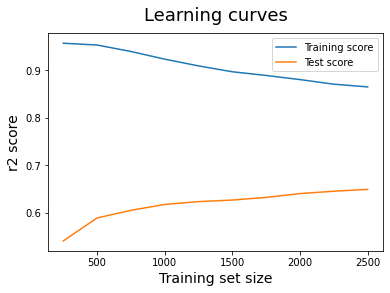

In [43]:
# Plot scores
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
plt.ylabel('r2 score', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves', fontsize = 18, y = 1.03)
plt.legend();

In [53]:
# Saving the best XGBoost model
pickle.dump(clf_xgb, open('xgboost.sav', 'wb'))

## Evaluation

#### Root Mean Squared Error

In [44]:
# Print different metrics to evaluate XGBoost model
print('Root mean squared error for XGBoost algorithm is: ', np.sqrt(mean_squared_error(y_test_log, y_pred_xgb)))

# Inverse transform the scaled revenue data from XGB model
absolute_y_cross = np.expm1(y_test_log)
absolute_y_pred = np.expm1(y_pred_xgb.reshape(-1,1))
print('Absolute root mean squared error: ', np.sqrt(mean_squared_error(absolute_y_cross, absolute_y_pred)))

Root mean squared error for XGBoost algorithm is:  1.176348523933463
Absolute root mean squared error:  72830701.19219504


#### Checking the absolute values that were predicted vs. the actual revenue figures

In [45]:
# Create dataframe with predicted values
comp_df = pd.DataFrame({"actual": np.expm1(y_test_log), "predictions": np.expm1(clf_xgb.predict(cross_set))})

# Add actual values to dataframe
# comp_df['actual'] = np.expm1(y_cross)

# Add column with difference of the two values
comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# Add column that shows the percent difference between predicted and actual value
comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
comp_df

,actual,predictions,difference,percent_diff,okay
2704,55011732.0,7.703416e+07,22022428.00,40.032239,bad
41501,11411644.0,5.910619e+06,-5501025.00,48.205368,bad
8554,39673161.0,1.562345e+07,-24049715.00,60.619609,bad
5383,14697005.0,1.391076e+07,-786241.00,5.349668,okay
4953,141407024.0,1.261734e+08,-15233624.00,10.772891,okay
...,...,...,...,...,...
6830,23574130.0,8.514661e+06,-15059469.00,63.881335,bad
12592,13071518.0,1.668276e+07,3611245.00,27.626822,bad
181,6000000.0,5.264042e+06,-735958.00,12.265967,okay
6213,40996665.0,3.460750e+07,-6389165.00,15.584597,okay


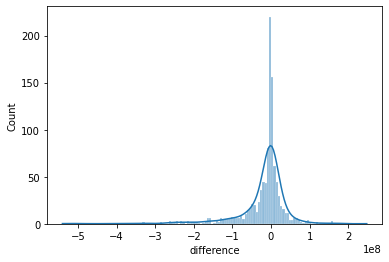

In [46]:
# visual check
sns.histplot(comp_df['difference'], kde=True, edgecolor='w');

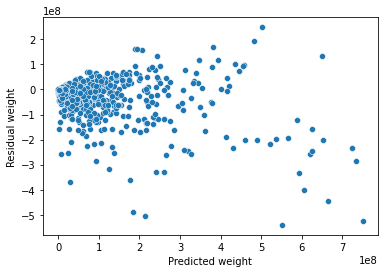

In [47]:
# Check with Residuals vs. Fitted scatterplot
sns.scatterplot(x=comp_df['predictions'], y=comp_df['difference'])
plt.xlabel('Predicted weight')
plt.ylabel('Residual weight');

In [48]:
# Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff').reset_index()


,index,actual,predictions,difference,percent_diff,okay
0,12508,400062763.0,4.011427e+08,1079957.00,0.269947,okay
1,273227,16180000.0,1.623070e+07,50699.00,0.313344,okay
2,2191,41637263.0,4.150619e+07,-131071.00,0.314793,okay
3,5220,76932943.0,7.733743e+07,404489.00,0.525768,okay
4,1468,149270999.0,1.501132e+08,842233.00,0.564231,okay
...,...,...,...,...,...,...
209,721,300854823.0,2.417354e+08,-59119431.00,19.650485,okay
210,45785,10126458.0,1.211806e+07,1991600.00,19.667291,okay
211,10149,4720371.0,3.789367e+06,-931003.75,19.723105,okay
212,1322,26010864.0,3.114106e+07,5130198.00,19.723289,okay


In [45]:
y_test_log.shape

(1066,)

#### Overfitting

In [52]:
# Checking for overfitting

# XGB
y_pred_train_xgb = clf_xgb.predict(xgb.DMatrix(X_train_processed_part, label=y_train_part_log))
print('Overfitting XGBoost:', np.sqrt(mean_squared_error(np.expm1(y_pred_train_xgb), np.expm1(y_train_part_log))), 'vs.', \
                              np.sqrt(mean_squared_error(np.expm1(y_pred_xgb), np.expm1(y_test_log))))

Overfitting XGBoost: 62765024.998697124 vs. 77071671.78319344


/home/sourav/.pyenv/versions/3.8.12/envs/lewagon/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


### Feature Importance

**_XGBoost_**

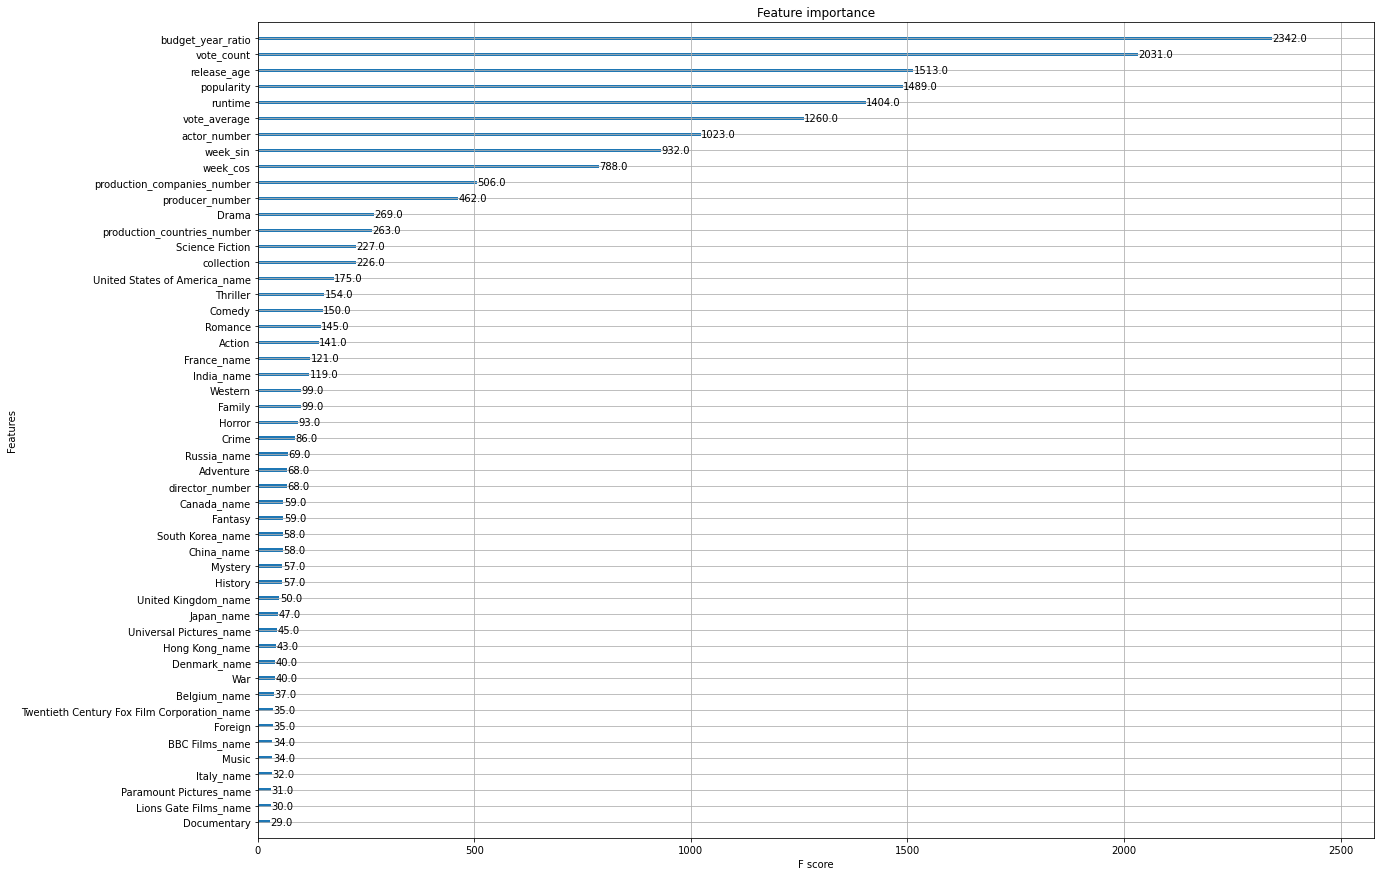

In [49]:
# Plot feature importance
fig, ax = plt.subplots(figsize=(20, 15))
xgb.plot_importance(clf_xgb, max_num_features=50, importance_type='weight', ax=ax);

## Predictions

In [ ]:
# # Create dataframe with predicted values
# comp_df = pd.DataFrame(np.expm1(), columns=['predictions'])

# # Add actual values to dataframe
# comp_df['actual'] = np.expm1(scaler_revenue.inverse_transform(y_cross))

# # Add column with difference of the two values
# comp_df['difference'] = comp_df['predictions'] - comp_df['actual']

# # Add column that shows the percent difference between predicted and actual value
# comp_df['percent_diff'] = abs(abs(comp_df['predictions'] / (comp_df['actual'])) - 1) * 100

# # Add column that designates a difference of less than 20% as 'okay' and 20% or more as 'bad'
# comp_df['okay'] = comp_df['percent_diff'].apply(lambda x: 'okay' if x < 20 else 'bad')
# comp_df

In [ ]:
# # Which movies had a difference of less than 20% in the predicted vs. the actual revenue value 
# comp_df[comp_df['okay'] == 'okay'].sort_values('percent_diff')

## PCA

In [60]:
pca = PCA(n_components=20)
pca_X_train = pca.fit_transform(X_train_processed_part)
pca_X_test = pca.transform(X_test_processed)
pca.explained_variance_ratio_

array([9.99989131e-01, 2.08780591e-06, 1.65686761e-06, 1.17205002e-06,
       9.42322754e-07, 6.93951637e-07, 5.86495352e-07, 5.25734822e-07,
       4.50887285e-07, 2.69243310e-07, 2.27893385e-07, 2.04244812e-07,
       1.56164343e-07, 1.39460697e-07, 1.26885500e-07, 1.08957638e-07,
       1.05259226e-07, 1.01733373e-07, 8.57188177e-08, 7.67459243e-08])

In [54]:
_

[['Steven Spielberg',
  'Ridley Scott',
  'Clint Eastwood',
  'Woody Allen',
  'Brian De Palma',
  'Martin Scorsese',
  'Robert Zemeckis',
  'Tim Burton',
  'Steven Soderbergh',
  'Ron Howard',
  'Alfred Hitchcock',
  'Joel Schumacher',
  'Renny Harlin',
  'Oliver Stone',
  'Robert Rodriguez',
  'Tony Scott',
  'Barry Levinson',
  'Richard Linklater',
  'Spike Lee',
  'Walter Hill',
  'Rob Reiner',
  'Francis Ford Coppola',
  'Bobby Farrelly',
  'Richard Donner',
  'Billy Wilder',
  'Michael Mann',
  'Barry Sonnenfeld',
  'Wolfgang Petersen',
  'F. Gary Gray',
  'Peter Hyams'],
 ['Brian Grazer',
  'Jerry Bruckheimer',
  'Joel Silver',
  'Tim Bevan',
  'Scott Rudin',
  'Neal H. Moritz',
  'John Davis',
  'Clint Eastwood',
  'Arnon Milchan',
  'Steve Golin',
  'Roger Birnbaum',
  'Michael Bay',
  'Gale Anne Hurd',
  'Lawrence Gordon',
  'Kevin Feige',
  'Albert R. Broccoli',
  'Tom Rosenberg',
  'Alfred Hitchcock',
  'Charles Roven',
  'John Hughes',
  'Mark Johnson',
  'Luc Besson',
  '